In [150]:
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc
import librosa
from librosa.feature import melspectrogram
import pickle

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dropout, SpatialDropout2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from buildfeats import build_rand_feat, check_data
# from model import get_conv_model
from cfg import Config


In [194]:
config = Config(feature_type='mels', n_mels=60)
config.step = int(16000 / 2.5)

In [198]:
##experimenting just on the 'curated' train set
df = pd.read_csv('data/train/roadsound_labels.csv', index_col=0)
df.set_index('fname', inplace=True)
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate
df.shape

(297, 2)

In [199]:
df = df[df.length > config.step/rate]
df.shape

(294, 2)

In [200]:
classes = list(np.unique(df.labels))
class_dist = df.groupby(['labels'])['length'].mean()
n_samples = 2 * int(df['length'].sum() / 0.1) # 40 * total length of audio
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [201]:
df, test_df, _ , _ = train_test_split(df, df.labels)

In [239]:
def rand_feats_exper(df, split): 
    X = []
    y = []
#     split='train'
    n_samples = 50000
    _min, _max = float('inf'), -float('inf')

    print('Building features for '+split)
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(classes, p=prob_dist)
        file = np.random.choice(df[df.labels == rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        rand_index = np.random.randint(0, wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index + config.step]
        if config.feature_type == 'mels':
            X_sample = melspectrogram(sample, rate, n_mels=60,
                                        n_fft=1028)
            X_sample = librosa.power_to_db(X_sample)
        if config.feature_type == 'raw':
            X_sample = sample
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(rand_class))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    # X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ## not needed for raw signal
    y = to_categorical(y)
    return X, y

In [240]:
X, y = rand_feats_exper(df, 'train')

Building features for train


In [241]:
X_test, y_test = rand_feats_exper(test_df, 'test')

Building features for test


In [203]:
print('X shape: ',X.shape)
print('y shape: ', y.shape)

X shape:  (10000, 26, 13)
y shape:  (10000, 5)


In [223]:
#flatten
X_train = X.reshape(len(X), -1)
X_test = X_test.reshape(len(X_test), -1)

In [225]:
X_test.shape

(2000, 338)

In [226]:
y_flat = np.argmax(y, axis=1)

In [227]:
class_weight = compute_class_weight('balanced',
                                    np.unique(y_flat),
                                    y_flat)

In [228]:
class_weight

array([2.36686391, 0.97799511, 0.72072072, 0.60150376, 1.98019802])

In [207]:
pca = PCA(n_components=20, random_state=1738)

In [209]:
X_pca = pca.fit_transform(X)

In [ ]:
X_pca.shape

In [163]:
input_shape_1d = (X_pca.shape[1],)

In [139]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                    strides=(1,1), padding='same', input_shape=input_shape_1d))    
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1,1),padding='same')) 
    # model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1),padding='same'))
    # model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model

In [210]:
shp = (X_train.shape[1],)
shp

(338,)

In [211]:
def get_ae_model():
    model = Sequential()
    model.add(Dense(128,  activation='relu', input_shape=shp))
    model.add(Dense(64,  activation='relu'))
    model.add(Dense(2,    activation='linear', name="bottleneck"))
    model.add(Dense(64,  activation='relu'))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(shp[0],  activation='linear'))
    model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
    return model

In [212]:
aemodel = get_ae_model()

In [213]:
aemodel.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               43392     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 130       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_38 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_39 (Dense)             (None, 338)               43602     
Total params: 103,892
Trainable params: 103,892
Non-trainable params: 0
________________________________________________

In [229]:
history = aemodel.fit(X_train.astype(float), X_train.astype(float),
                     batch_size=128,
                     epochs=100,
                     validation_data=(X_test, X_test),
                     class_weight=class_weight
                     )

Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 0s 114us/sample - loss: 0.0023 - accuracy: 0.0500 - val_loss: 0.0028 - val_accuracy: 0.0525
Epoch 2/100
2000/2000 [==============================] - 0s 78us/sample - loss: 0.0023 - accuracy: 0.0480 - val_loss: 0.0028 - val_accuracy: 0.0550
Epoch 3/100
2000/2000 [==============================] - 0s 91us/sample - loss: 0.0023 - accuracy: 0.0520 - val_loss: 0.0028 - val_accuracy: 0.0525
Epoch 4/100
2000/2000 [==============================] - 0s 71us/sample - loss: 0.0022 - accuracy: 0.0615 - val_loss: 0.0028 - val_accuracy: 0.0495
Epoch 5/100
2000/2000 [==============================] - 0s 62us/sample - loss: 0.0022 - accuracy: 0.0605 - val_loss: 0.0027 - val_accuracy: 0.0650
Epoch 6/100
2000/2000 [==============================] - 0s 73us/sample - loss: 0.0022 - accuracy: 0.0625 - val_loss: 0.0029 - val_accuracy: 0.0490
Epoch 7/100
2000/2000 [==============================] - 0s 75u

2000/2000 [==============================] - 0s 110us/sample - loss: 0.0021 - accuracy: 0.0530 - val_loss: 0.0028 - val_accuracy: 0.0420
Epoch 56/100
2000/2000 [==============================] - 0s 101us/sample - loss: 0.0021 - accuracy: 0.0595 - val_loss: 0.0028 - val_accuracy: 0.0360
Epoch 57/100
2000/2000 [==============================] - 0s 77us/sample - loss: 0.0020 - accuracy: 0.0605 - val_loss: 0.0028 - val_accuracy: 0.0400
Epoch 58/100
2000/2000 [==============================] - 0s 62us/sample - loss: 0.0020 - accuracy: 0.0560 - val_loss: 0.0028 - val_accuracy: 0.0570
Epoch 59/100
2000/2000 [==============================] - 0s 91us/sample - loss: 0.0020 - accuracy: 0.0575 - val_loss: 0.0028 - val_accuracy: 0.0430
Epoch 60/100
2000/2000 [==============================] - 0s 97us/sample - loss: 0.0021 - accuracy: 0.0465 - val_loss: 0.0028 - val_accuracy: 0.0485
Epoch 61/100
2000/2000 [==============================] - 0s 77us/sample - loss: 0.0021 - accuracy: 0.0635 - val_loss

Text(0.5, 0, 'epoch')

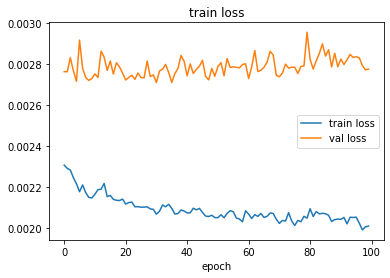

In [230]:
plt.title("train loss")
plt.plot( history.history["loss"] , label='train loss')
plt.plot( history.history["val_loss"], label='val loss' )
plt.legend()

plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

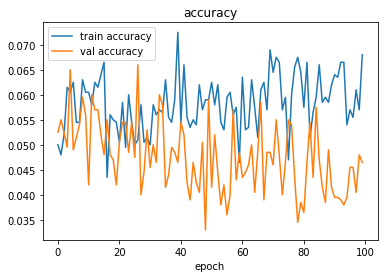

In [231]:
plt.title("accuracy")
plt.plot( history.history["accuracy"] , label='train accuracy')
plt.plot( history.history["val_accuracy"], label='val accuracy' )
plt.legend()

plt.xlabel("epoch")

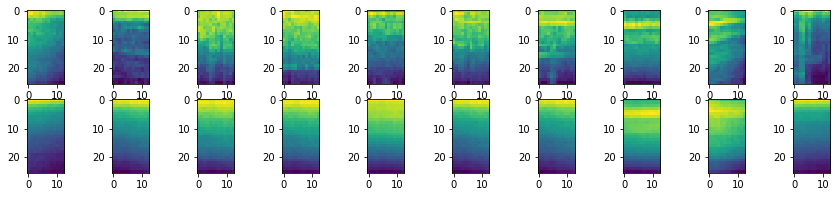

In [235]:
im_i=15

fig, axs = plt.subplots(2,10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow( X_train[i:i+1].reshape(26,13) )
    axs[1][i].imshow( aemodel.predict( X_train[i:i+1] ).reshape(26,13) )
